In [10]:
from util.log import plot_ts_result, regression_results, calc_diff
from util.process import MyDataset, Modeling
from util.model import Transformer, LSTM, RNN
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2
results = {
    "model_name":[],
    "y":[],
    "explained_variance": [],
    "r2": [],
    "mae": [],
    "mse": [],
    "rmse": []
}

In [13]:
def log_result(true_value, pred_value):
    result = regression_results(true_value, pred_value)
    plot_ts_result(true_value, pred_value)
    calc_diff(true_value, pred_value)
    plt.show()
    return result

def save_log(model_name, y, result):
    global results
    results["model_name"].append(model_name)
    results["y"].append(y)
    for k, v in result.items():
        results[k].append(v)

def main(x_cols, y_cols):
    data = MyDataset(df, x_cols, y_cols)
    learning_rate = 0.01
    train_loader, test_loader = data.preprocessing(train_ratio=0.8)
    model_list = ["XGBoost", "RNN", "LSTM", "Transformer"]
    histories = {model: None for model in model_list}
    # empty dataframe for save result
    pred_df_train = pd.DataFrame(columns=["answer"] + model_list)
    pred_df_test = pd.DataFrame(columns=["answer"] + model_list)

    train_true_val = None
    test_true_val = None

    # Deep Learning
    for model in [RNN, LSTM, Transformer]:
        print("-----",model.name,"-----")
        modeling = Modeling(model, data, lr=learning_rate)
        history = modeling.train( 
            epochs=100, 
            train_loader=train_loader,
            test_loader=test_loader,
        )
        train_true_val, pred_val = modeling.eval(train_loader, data.y_train)
        pred_df_train["answer"] = train_true_val.reshape(-1)
        pred_df_train[model.name] = pred_val
        
        test_true_val, pred_val = modeling.eval(test_loader, data.y_test)
        pred_df_test["answer"] = test_true_val.reshape(-1)
        pred_df_test[model.name] = pred_val

        result = log_result(test_true_val, pred_val)
        save_log(model.name, y_cols[0], result)
        
        histories[model.name] = history

    print("-----", "XGBoost", "-----")
    train_x_set = data.x_train_no_window
    test_x_set = data.x_test_no_window
    
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=learning_rate, n_jobs=4)
    model.fit(train_x_set, train_true_val)
    pred_df_train["XGBoost"] = model.predict(train_x_set)
    pred_df_train["answer"] = train_true_val
    pred_df_test["XGBoost"] = model.predict(test_x_set)
    pred_df_test["answer"] = test_true_val

    result = log_result(pred_df_test["answer"], pred_df_test["XGBoost"])
    save_log("XGBoost", y_cols[0], result)

    return pred_df_train, pred_df_test, histories

내부 온도

----- RNN -----
Using device: cuda
Epoch 10, Traini Loss: 6.3489, Val Loss: 11.5091
Epoch 20, Traini Loss: 9.6582, Val Loss: 12.1584
Epoch 30, Traini Loss: 5.9679, Val Loss: 10.7517
Epoch 40, Traini Loss: 5.5600, Val Loss: 14.6799
Epoch 50, Traini Loss: 4.4269, Val Loss: 12.4413
Epoch 60, Traini Loss: 5.5540, Val Loss: 12.0265
Epoch 70, Traini Loss: 6.7331, Val Loss: 12.6676
Epoch 80, Traini Loss: 6.6762, Val Loss: 13.3049
Epoch 90, Traini Loss: 7.6843, Val Loss: 11.6464
Epoch 100, Traini Loss: 4.4101, Val Loss: 11.4308
explained_variance:  0.5617
r2:  0.5422
MAE:  2.7103
MSE:  11.4308
RMSE:  3.381


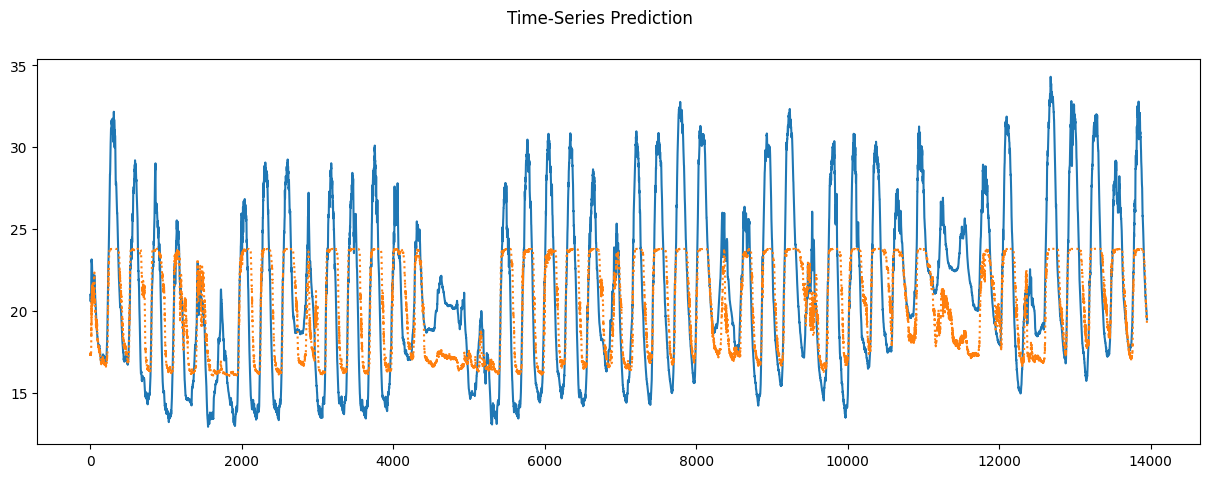

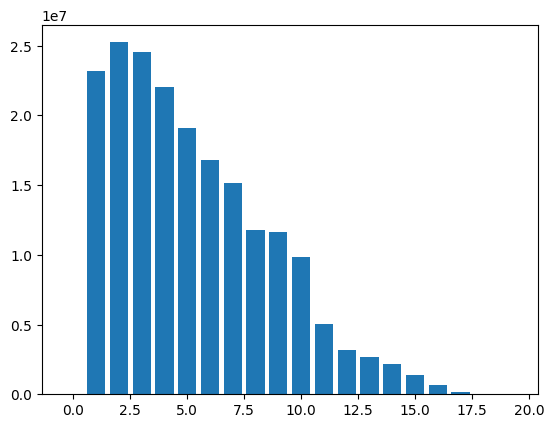

----- LSTM -----
Using device: cuda
Epoch 10, Traini Loss: 5.6204, Val Loss: 5.3799
Epoch 20, Traini Loss: 6.6875, Val Loss: 4.8521
Epoch 30, Traini Loss: 3.4196, Val Loss: 4.9582
Epoch 40, Traini Loss: 2.6892, Val Loss: 5.8016
Epoch 50, Traini Loss: 4.0669, Val Loss: 5.0234
Epoch 60, Traini Loss: 3.9197, Val Loss: 4.7719
Epoch 70, Traini Loss: 5.1728, Val Loss: 4.6355
Epoch 80, Traini Loss: 2.8746, Val Loss: 5.0306
Epoch 90, Traini Loss: 2.1653, Val Loss: 5.3728
Epoch 100, Traini Loss: 2.8791, Val Loss: 5.3277
explained_variance:  0.8258
r2:  0.7866
MAE:  1.9452
MSE:  5.3277
RMSE:  2.3082


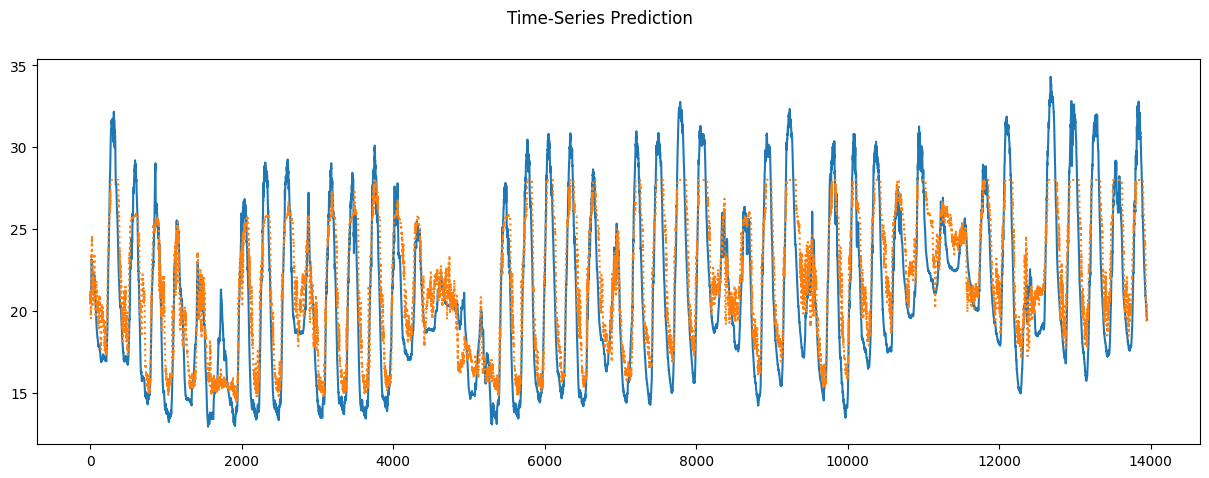

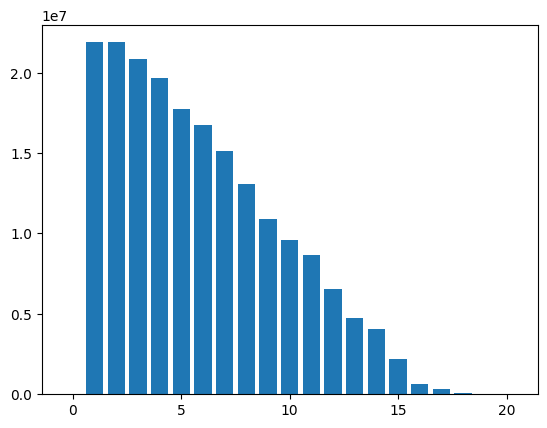

----- Transformer -----
Using device: cuda
Epoch 10, Traini Loss: 7.2656, Val Loss: 6.9375
Epoch 20, Traini Loss: 8.9568, Val Loss: 11.1371
Epoch 30, Traini Loss: 6.7395, Val Loss: 6.7085
Epoch 40, Traini Loss: 6.9453, Val Loss: 5.5427
Epoch 50, Traini Loss: 3.3743, Val Loss: 5.7652
Epoch 60, Traini Loss: 3.1831, Val Loss: 6.0292
Epoch 70, Traini Loss: 5.5545, Val Loss: 6.8309
Epoch 80, Traini Loss: 4.1269, Val Loss: 5.7021
Epoch 90, Traini Loss: 5.2941, Val Loss: 5.2567
Epoch 100, Traini Loss: 5.9100, Val Loss: 5.5545
explained_variance:  0.7786
r2:  0.7776
MAE:  1.8881
MSE:  5.5545
RMSE:  2.3568


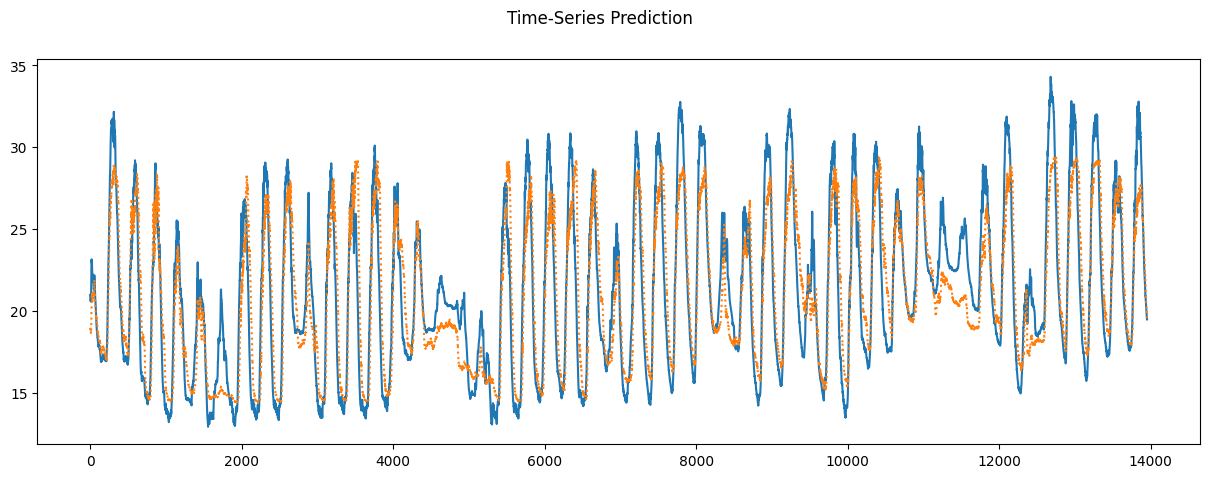

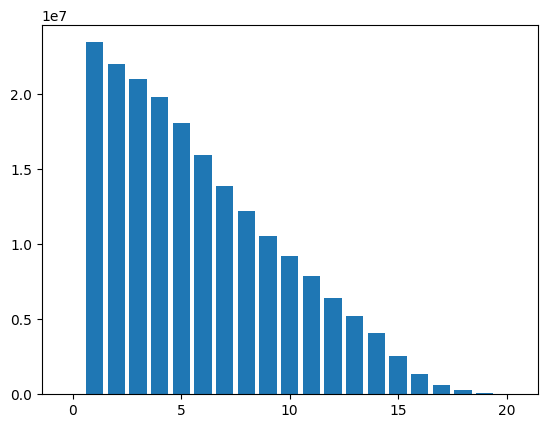

----- XGBoost -----
explained_variance:  0.7674
r2:  0.7618
MAE:  2.013
MSE:  5.9477
RMSE:  2.4388


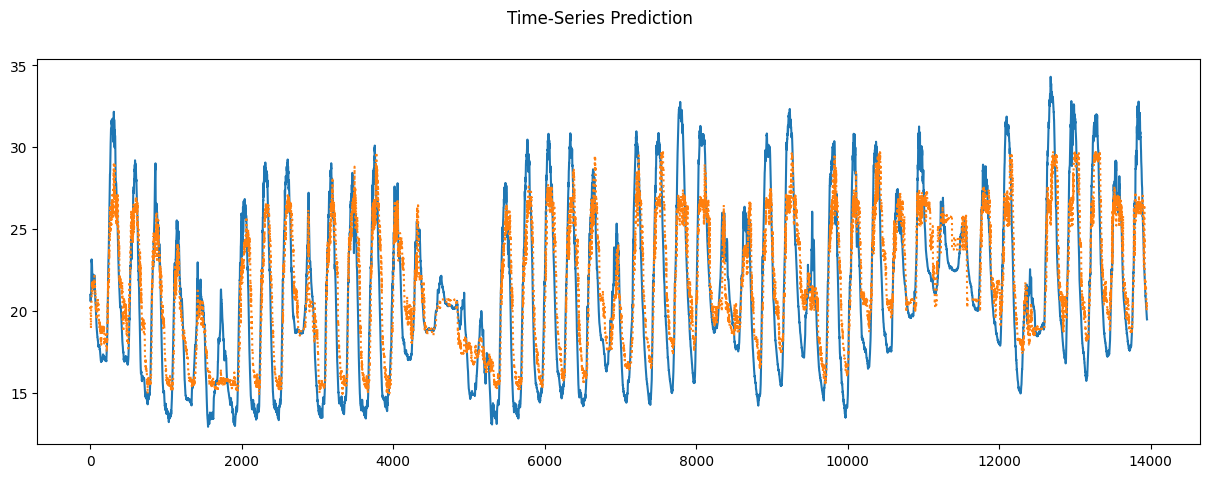

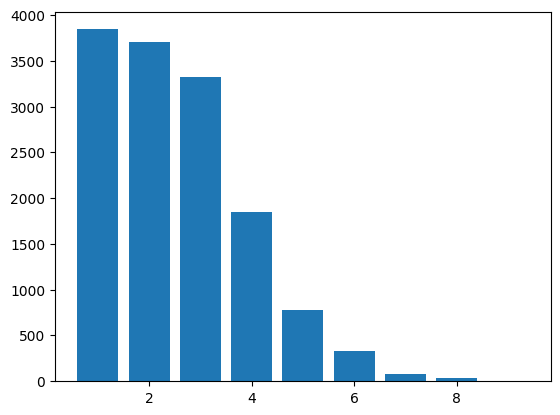

In [14]:
x_cols = ["EXTN_TPRT", "INNER_HMDT"] 
y_cols = ["INNER_TPRT"]
pred_df_train, pred_df_test, _ = main(x_cols, y_cols)
pred_df_train.to_csv(f"data/pred_{y_cols[0]}_train.csv", index=False)
pred_df_test.to_csv(f"data/pred_{y_cols[0]}_test.csv", index=False)

내부 습도

----- RNN -----
Using device: cuda
Epoch 10, Traini Loss: 42.5186, Val Loss: 166.8497
Epoch 20, Traini Loss: 97.0468, Val Loss: 127.8705
Epoch 30, Traini Loss: 56.3347, Val Loss: 129.7370
Epoch 40, Traini Loss: 66.0043, Val Loss: 142.7335
Epoch 50, Traini Loss: 56.6856, Val Loss: 157.3998
Epoch 60, Traini Loss: 87.7526, Val Loss: 146.5205
Epoch 70, Traini Loss: 55.7118, Val Loss: 164.0850
Epoch 80, Traini Loss: 122.6625, Val Loss: 155.6996
Epoch 90, Traini Loss: 45.3264, Val Loss: 168.1070
Epoch 100, Traini Loss: 72.2241, Val Loss: 206.9195
explained_variance:  0.1094
r2:  -0.3796
MAE:  11.358
MSE:  206.9195
RMSE:  14.3847


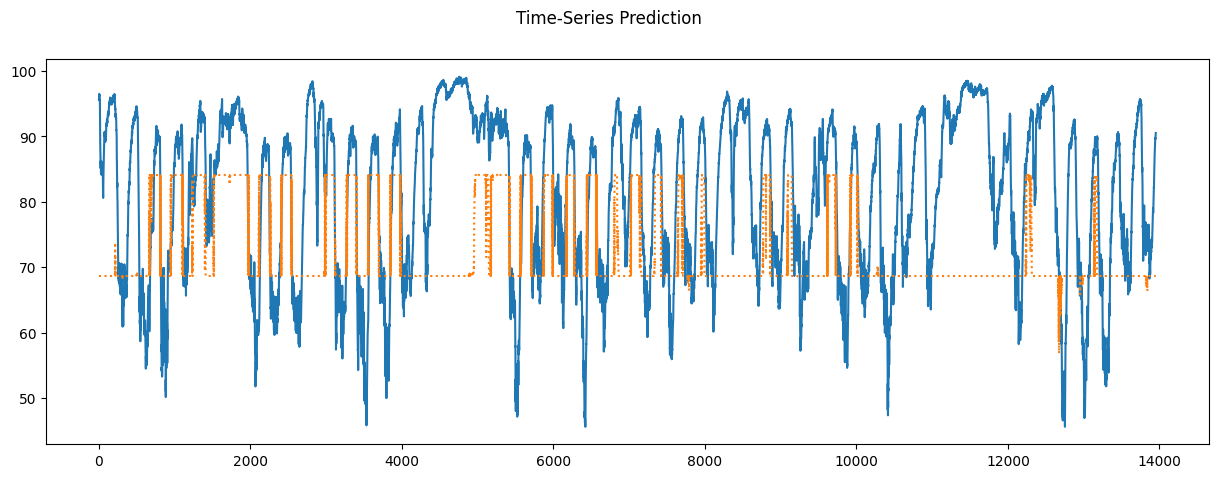

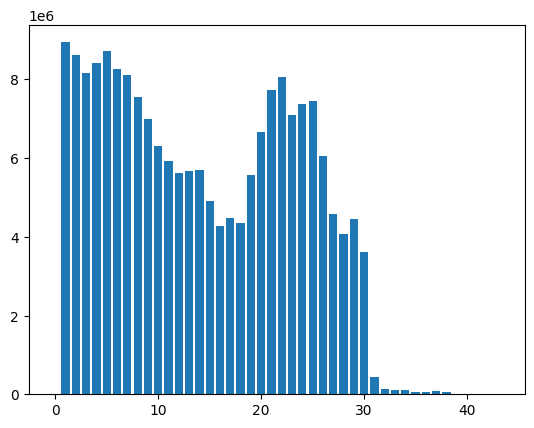

----- LSTM -----
Using device: cuda
Epoch 10, Traini Loss: 45.0221, Val Loss: 174.7225
Epoch 20, Traini Loss: 84.0164, Val Loss: 146.3930
Epoch 30, Traini Loss: 55.5230, Val Loss: 151.3977
Epoch 40, Traini Loss: 34.9825, Val Loss: 151.6358
Epoch 50, Traini Loss: 30.4375, Val Loss: 147.5324
Epoch 60, Traini Loss: 60.1275, Val Loss: 138.2911
Epoch 70, Traini Loss: 61.2497, Val Loss: 130.4865
Epoch 80, Traini Loss: 61.8535, Val Loss: 138.9071
Epoch 90, Traini Loss: 29.2528, Val Loss: 143.2808
Epoch 100, Traini Loss: 42.4444, Val Loss: 134.5425
explained_variance:  0.4476
r2:  0.103
MAE:  9.2557
MSE:  134.5425
RMSE:  11.5992


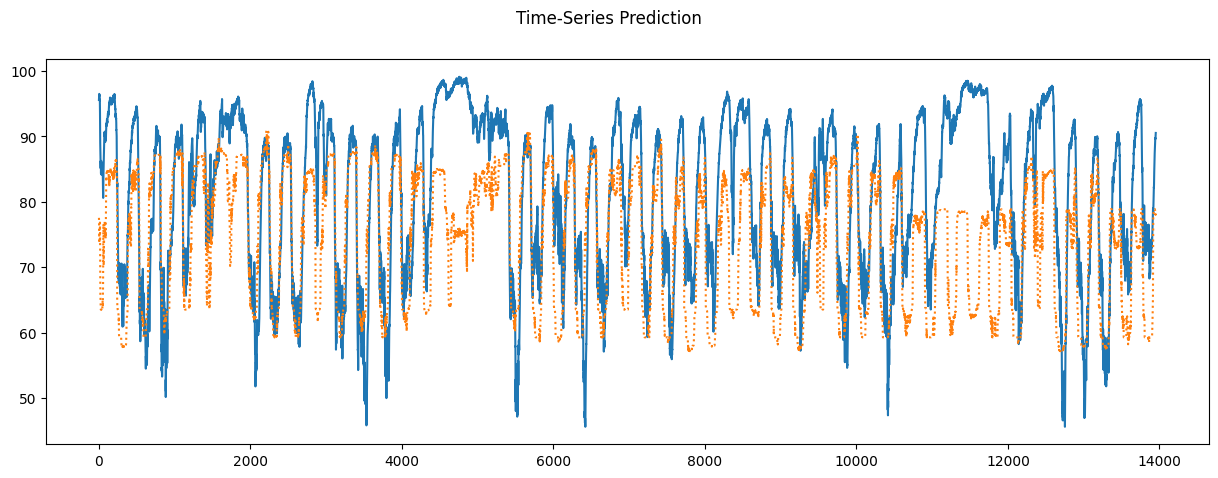

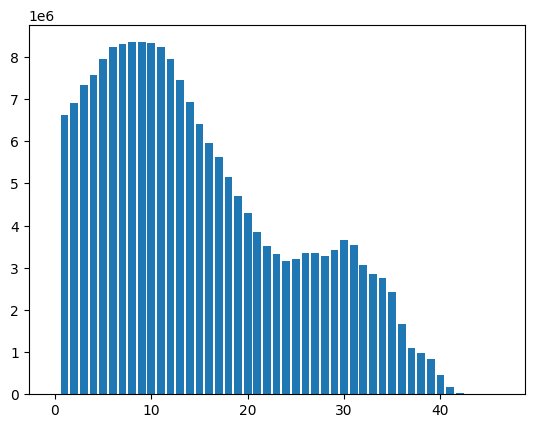

----- Transformer -----
Using device: cuda
Epoch 10, Traini Loss: 84.5355, Val Loss: 132.1581
Epoch 20, Traini Loss: 32.3272, Val Loss: 98.7014
Epoch 30, Traini Loss: 61.6249, Val Loss: 160.1973
Epoch 40, Traini Loss: 84.3098, Val Loss: 134.1037
Epoch 50, Traini Loss: 64.4018, Val Loss: 157.2906
Epoch 60, Traini Loss: 68.9501, Val Loss: 257.0550
Epoch 70, Traini Loss: 86.2022, Val Loss: 108.2850
Epoch 80, Traini Loss: 58.5574, Val Loss: 159.9705
Epoch 90, Traini Loss: 58.3054, Val Loss: 147.8099
Epoch 100, Traini Loss: 46.2767, Val Loss: 160.7896
explained_variance:  0.4014
r2:  -0.072
MAE:  10.4353
MSE:  160.7896
RMSE:  12.6803


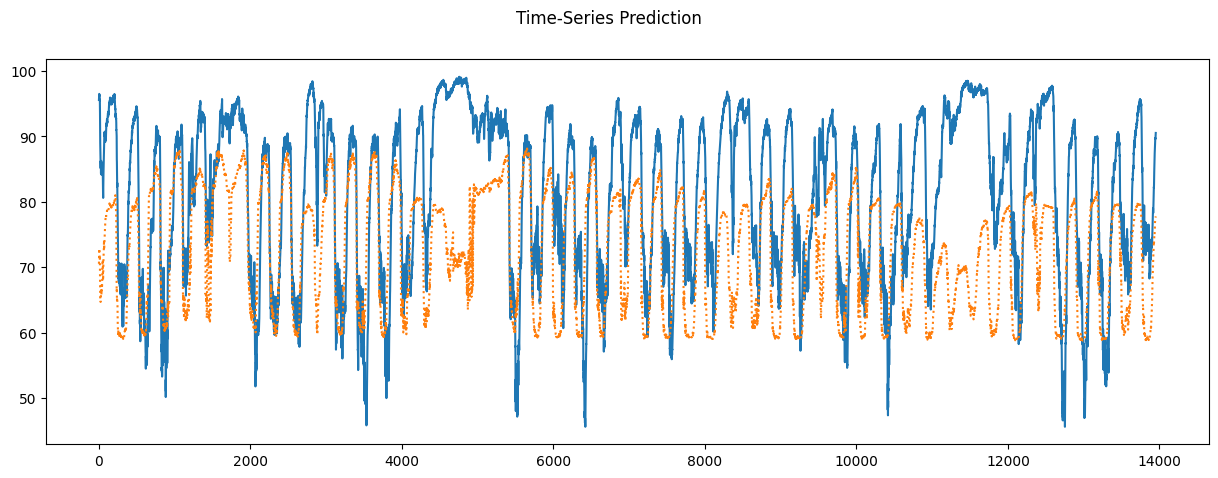

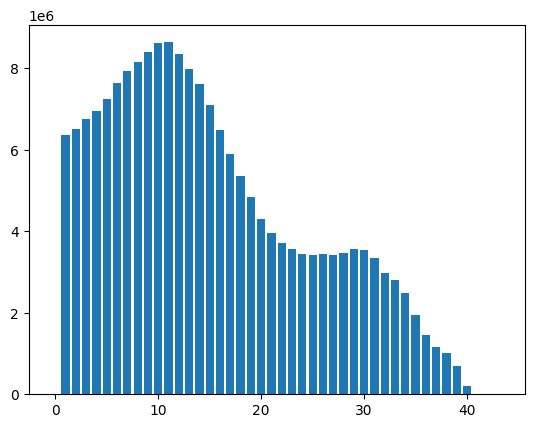

----- XGBoost -----
explained_variance:  0.3133
r2:  -0.3757
MAE:  11.794
MSE:  206.3335
RMSE:  14.3643


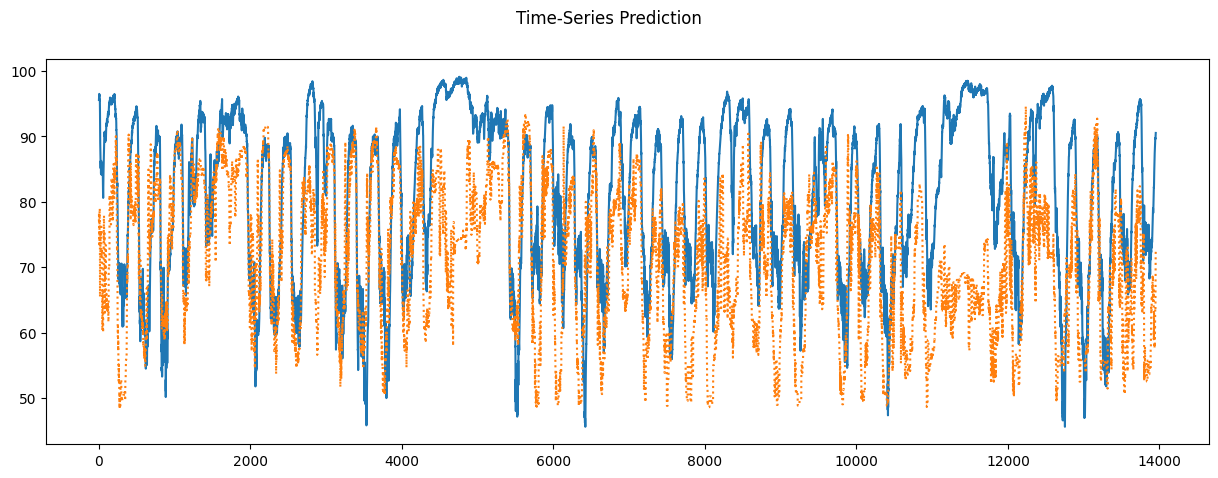

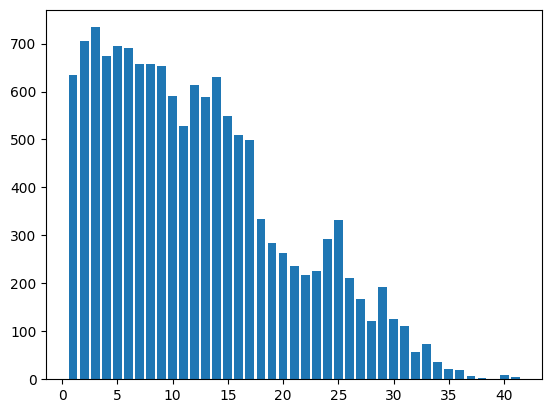

In [15]:
x_cols = ["EXTN_TPRT", "INNER_TPRT", "NTSLT_SPL_PH_LVL", "NTSLT_SPL_ELCDT"] #"DWP_TPRT"를 넣으면 Transformer에서 거의 100점짜리 답안이 나옴
y_cols = ["INNER_HMDT"]
pred_df_train, pred_df_test, _ = main(x_cols, y_cols)
pred_df_train.to_csv(f"data/pred_{y_cols[0]}_train.csv", index=False)
pred_df_test.to_csv(f"data/pred_{y_cols[0]}_test.csv", index=False)

난방온도

----- RNN -----
Using device: cuda
Epoch 10, Traini Loss: 5.3747, Val Loss: 3.3714
Epoch 20, Traini Loss: 4.6888, Val Loss: 3.3342
Epoch 30, Traini Loss: 5.0916, Val Loss: 4.2539
Epoch 40, Traini Loss: 3.5273, Val Loss: 3.3548
Epoch 50, Traini Loss: 4.5178, Val Loss: 3.0830
Epoch 60, Traini Loss: 4.2568, Val Loss: 3.3125
Epoch 70, Traini Loss: 5.2070, Val Loss: 3.8544
Epoch 80, Traini Loss: 3.9013, Val Loss: 4.0665
Epoch 90, Traini Loss: 4.3991, Val Loss: 3.4404
Epoch 100, Traini Loss: 5.1304, Val Loss: 3.2531
explained_variance:  0.0
r2:  -0.0778
MAE:  1.5696
MSE:  3.2531
RMSE:  1.8036


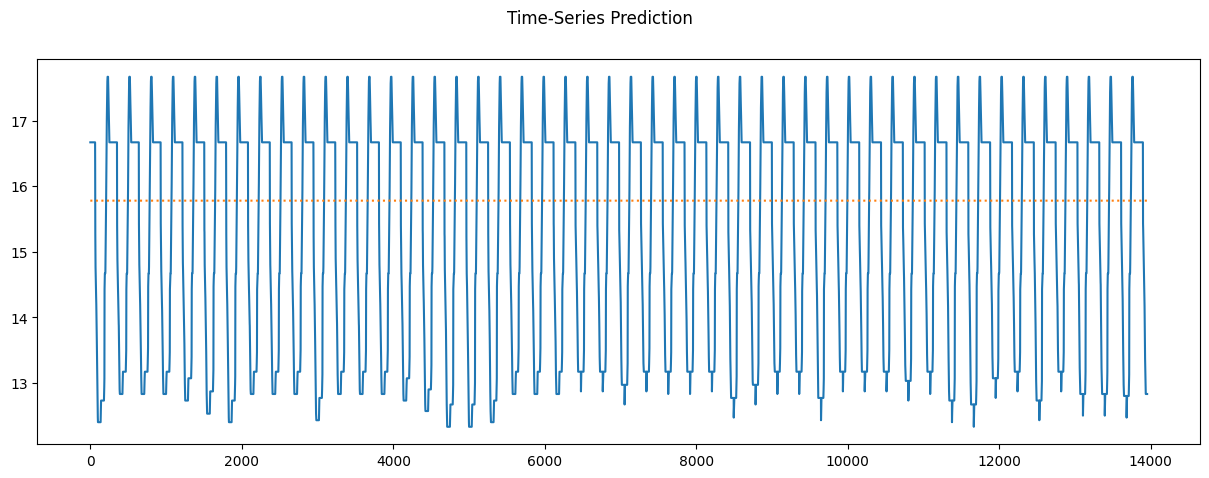

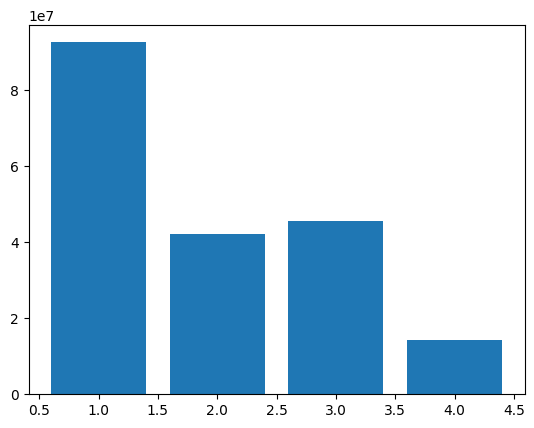

----- LSTM -----
Using device: cuda
Epoch 10, Traini Loss: 4.2446, Val Loss: 3.6406
Epoch 20, Traini Loss: 1.9999, Val Loss: 4.2522
Epoch 30, Traini Loss: 2.1821, Val Loss: 3.3150
Epoch 40, Traini Loss: 2.3187, Val Loss: 3.6071
Epoch 50, Traini Loss: 2.6710, Val Loss: 3.5375
Epoch 60, Traini Loss: 2.7314, Val Loss: 3.6656
Epoch 70, Traini Loss: 2.6219, Val Loss: 4.0798
Epoch 80, Traini Loss: 0.9637, Val Loss: 3.5477
Epoch 90, Traini Loss: 2.4349, Val Loss: 4.0202
Epoch 100, Traini Loss: 1.9157, Val Loss: 3.5160
explained_variance:  0.1251
r2:  -0.1648
MAE:  1.5207
MSE:  3.516
RMSE:  1.8751


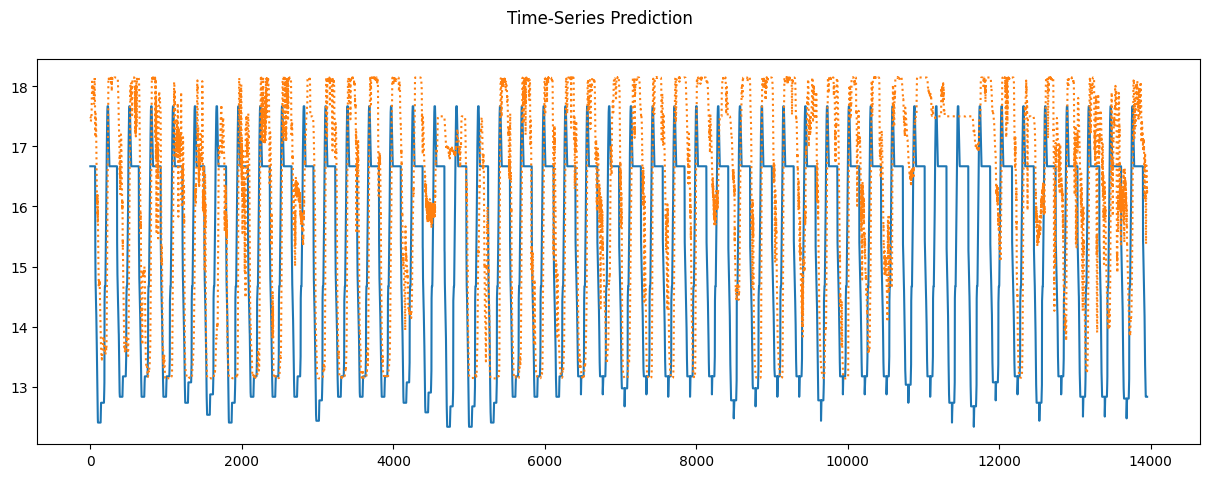

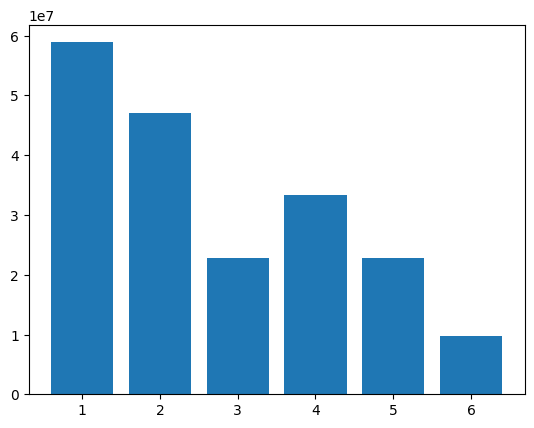

----- Transformer -----
Using device: cuda
Epoch 10, Traini Loss: 1.4738, Val Loss: 1.9529
Epoch 20, Traini Loss: 1.4443, Val Loss: 3.5707
Epoch 30, Traini Loss: 1.4472, Val Loss: 3.4359
Epoch 40, Traini Loss: 1.3160, Val Loss: 1.8261
Epoch 50, Traini Loss: 2.2162, Val Loss: 3.1171
Epoch 60, Traini Loss: 1.9125, Val Loss: 3.0039
Epoch 70, Traini Loss: 0.8846, Val Loss: 4.1025
Epoch 80, Traini Loss: 1.3976, Val Loss: 3.9510
Epoch 90, Traini Loss: 2.8597, Val Loss: 5.2318
Epoch 100, Traini Loss: 1.6488, Val Loss: 5.2189
explained_variance:  0.0227
r2:  -0.729
MAE:  1.8391
MSE:  5.2189
RMSE:  2.2845


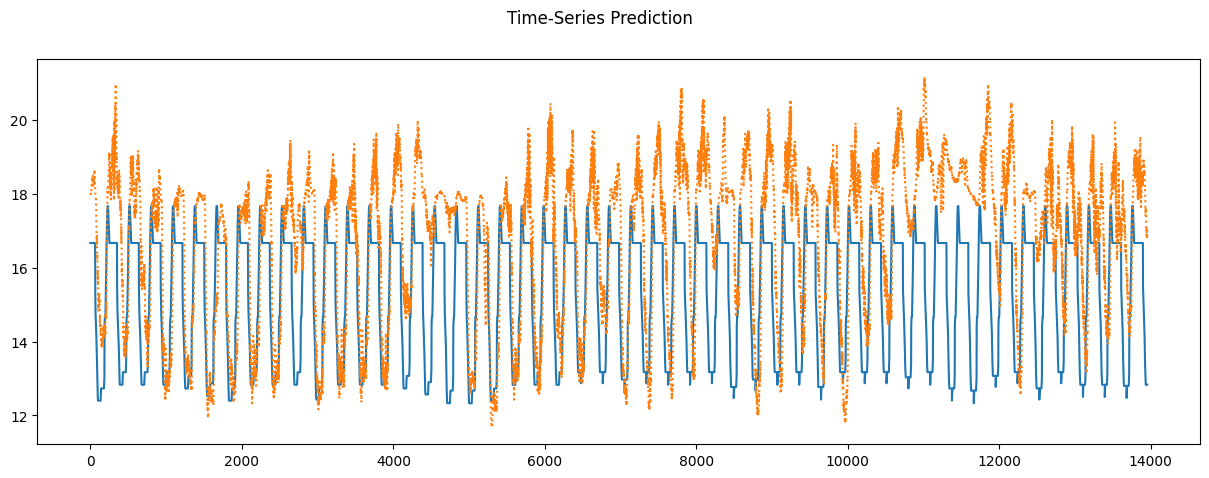

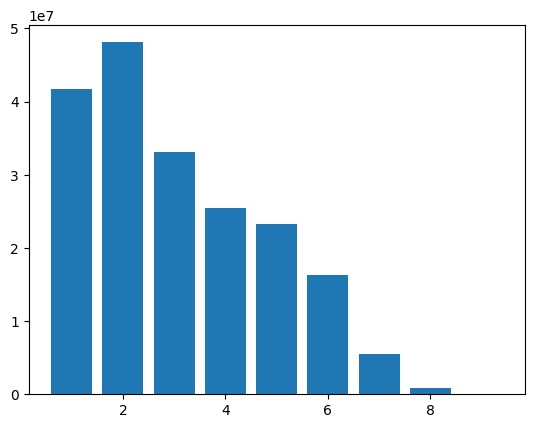

----- XGBoost -----
explained_variance:  -0.0827
r2:  -0.3977
MAE:  1.5921
MSE:  4.2188
RMSE:  2.054


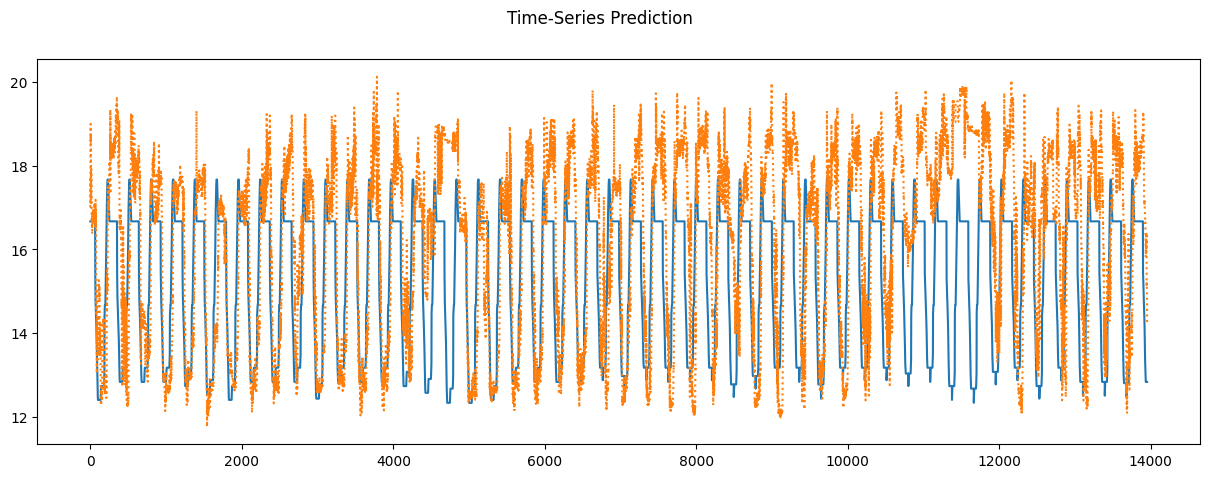

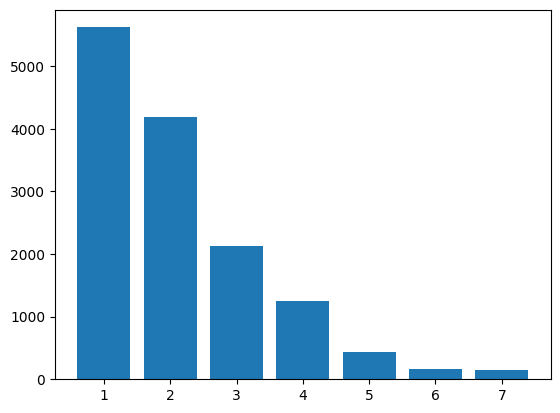

In [16]:
x_cols = ["INNER_TPRT", "INNER_HMDT", "EXTN_TPRT","WATER_LACK_VL"] 
y_cols = ["HTNG_TPRT_1"]
pred_df_train, pred_df_test, _ = main(x_cols, y_cols)
pred_df_train.to_csv(f"data/pred_{y_cols[0]}_train.csv", index=False)
pred_df_test.to_csv(f"data/pred_{y_cols[0]}_test.csv", index=False)

최종화방번호

----- RNN -----
Using device: cuda
Epoch 10, Traini Loss: 34.7662, Val Loss: 93.0702
Epoch 20, Traini Loss: 33.6502, Val Loss: 156.2012
Epoch 30, Traini Loss: 29.2327, Val Loss: 131.1192
Epoch 40, Traini Loss: 39.6537, Val Loss: 118.1100
Epoch 50, Traini Loss: 30.8838, Val Loss: 122.5436
Epoch 60, Traini Loss: 32.0983, Val Loss: 147.0855
Epoch 70, Traini Loss: 31.4780, Val Loss: 125.3518
Epoch 80, Traini Loss: 34.7552, Val Loss: 102.6689
Epoch 90, Traini Loss: 34.2064, Val Loss: 136.3687
Epoch 100, Traini Loss: 42.8658, Val Loss: 144.5746
explained_variance:  0.0
r2:  -122.2721
MAE:  11.975
MSE:  144.5746
RMSE:  12.0239


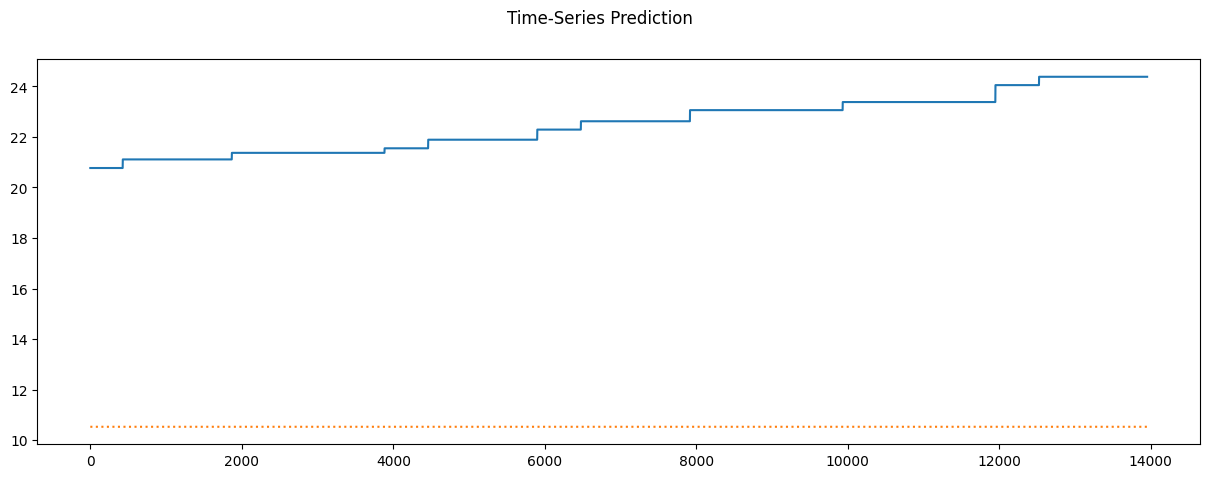

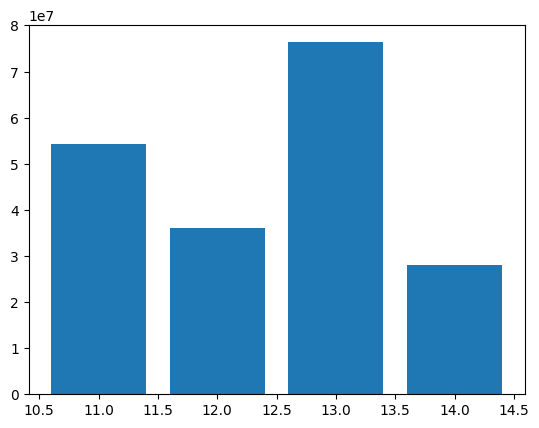

----- LSTM -----
Using device: cuda
Epoch 10, Traini Loss: 40.0611, Val Loss: 134.9701
Epoch 20, Traini Loss: 30.4771, Val Loss: 128.1099
Epoch 30, Traini Loss: 23.0298, Val Loss: 135.5536
Epoch 40, Traini Loss: 24.2135, Val Loss: 115.8686
Epoch 50, Traini Loss: 24.8094, Val Loss: 128.6686
Epoch 60, Traini Loss: 19.7477, Val Loss: 116.8955
Epoch 70, Traini Loss: 24.3394, Val Loss: 143.8732
Epoch 80, Traini Loss: 20.9389, Val Loss: 113.5845
Epoch 90, Traini Loss: 24.6618, Val Loss: 110.9960
Epoch 100, Traini Loss: 24.7602, Val Loss: 121.9748
explained_variance:  -6.3689
r2:  -103.0022
MAE:  10.6458
MSE:  121.9748
RMSE:  11.0442


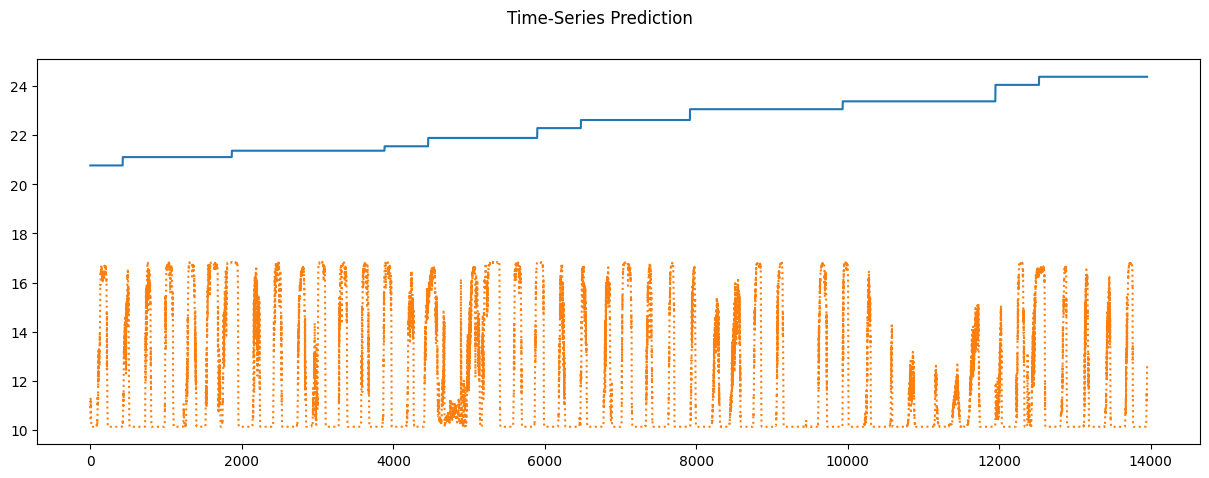

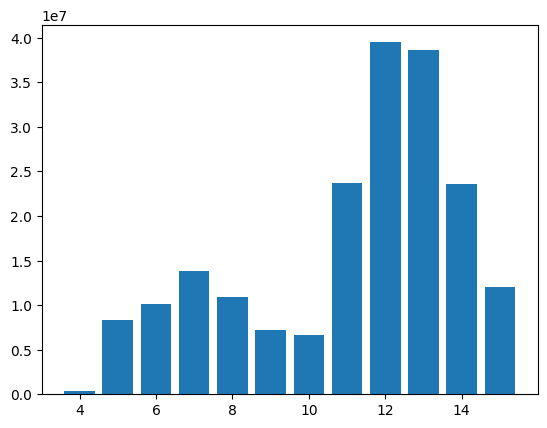

----- Transformer -----
Using device: cuda
Epoch 10, Traini Loss: 40.6312, Val Loss: 123.2374
Epoch 20, Traini Loss: 32.2269, Val Loss: 127.6984
Epoch 30, Traini Loss: 32.2956, Val Loss: 137.2503
Epoch 40, Traini Loss: 40.5808, Val Loss: 129.0039
Epoch 50, Traini Loss: 26.6033, Val Loss: 126.1031
Epoch 60, Traini Loss: 28.6626, Val Loss: 120.5102
Epoch 70, Traini Loss: 40.6075, Val Loss: 129.9661
Epoch 80, Traini Loss: 25.6456, Val Loss: 123.7851
Epoch 90, Traini Loss: 32.4621, Val Loss: nan
Epoch 100, Traini Loss: 33.5632, Val Loss: nan


ValueError: Input contains NaN.

In [17]:
# 입력 데이터가 seasonality가 있지만 출력 데이터에 없는 경우, 어떤 모델을 쓰든 성능이 좋지 않음
x_cols = ["EXTN_TPRT", "INNER_TPRT", "INNER_HMDT", "NTSLT_SPL_PH_LVL"] 
y_cols = ["LAST_FWRCT_NO"]
pred_df_train, pred_df_test, _ = main(x_cols, y_cols)
pred_df_train.to_csv(f"data/pred_{y_cols[0]}_train.csv", index=False)
pred_df_test.to_csv(f"data/pred_{y_cols[0]}_test.csv", index=False)

결과 저장

In [18]:
results_df = pd.DataFrame(results)
# results_df.to_csv("data/pred_results.csv", index=False)
results_df.head()

,model_name,y,explained_variance,r2,mae,mse,rmse
0,RNN,INNER_TPRT,0.5617,0.5422,2.7103,11.4308,3.3810
1,LSTM,INNER_TPRT,0.8258,0.7866,1.9452,5.3277,2.3082
2,Transformer,INNER_TPRT,0.7786,0.7776,1.8881,5.5545,2.3568
3,XGBoost,INNER_TPRT,0.7674,0.7618,2.0130,5.9477,2.4388
4,RNN,INNER_HMDT,0.1094,-0.3796,11.3580,206.9195,14.3847
